In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [12]:
df = pd.read_csv('processed-data.csv')

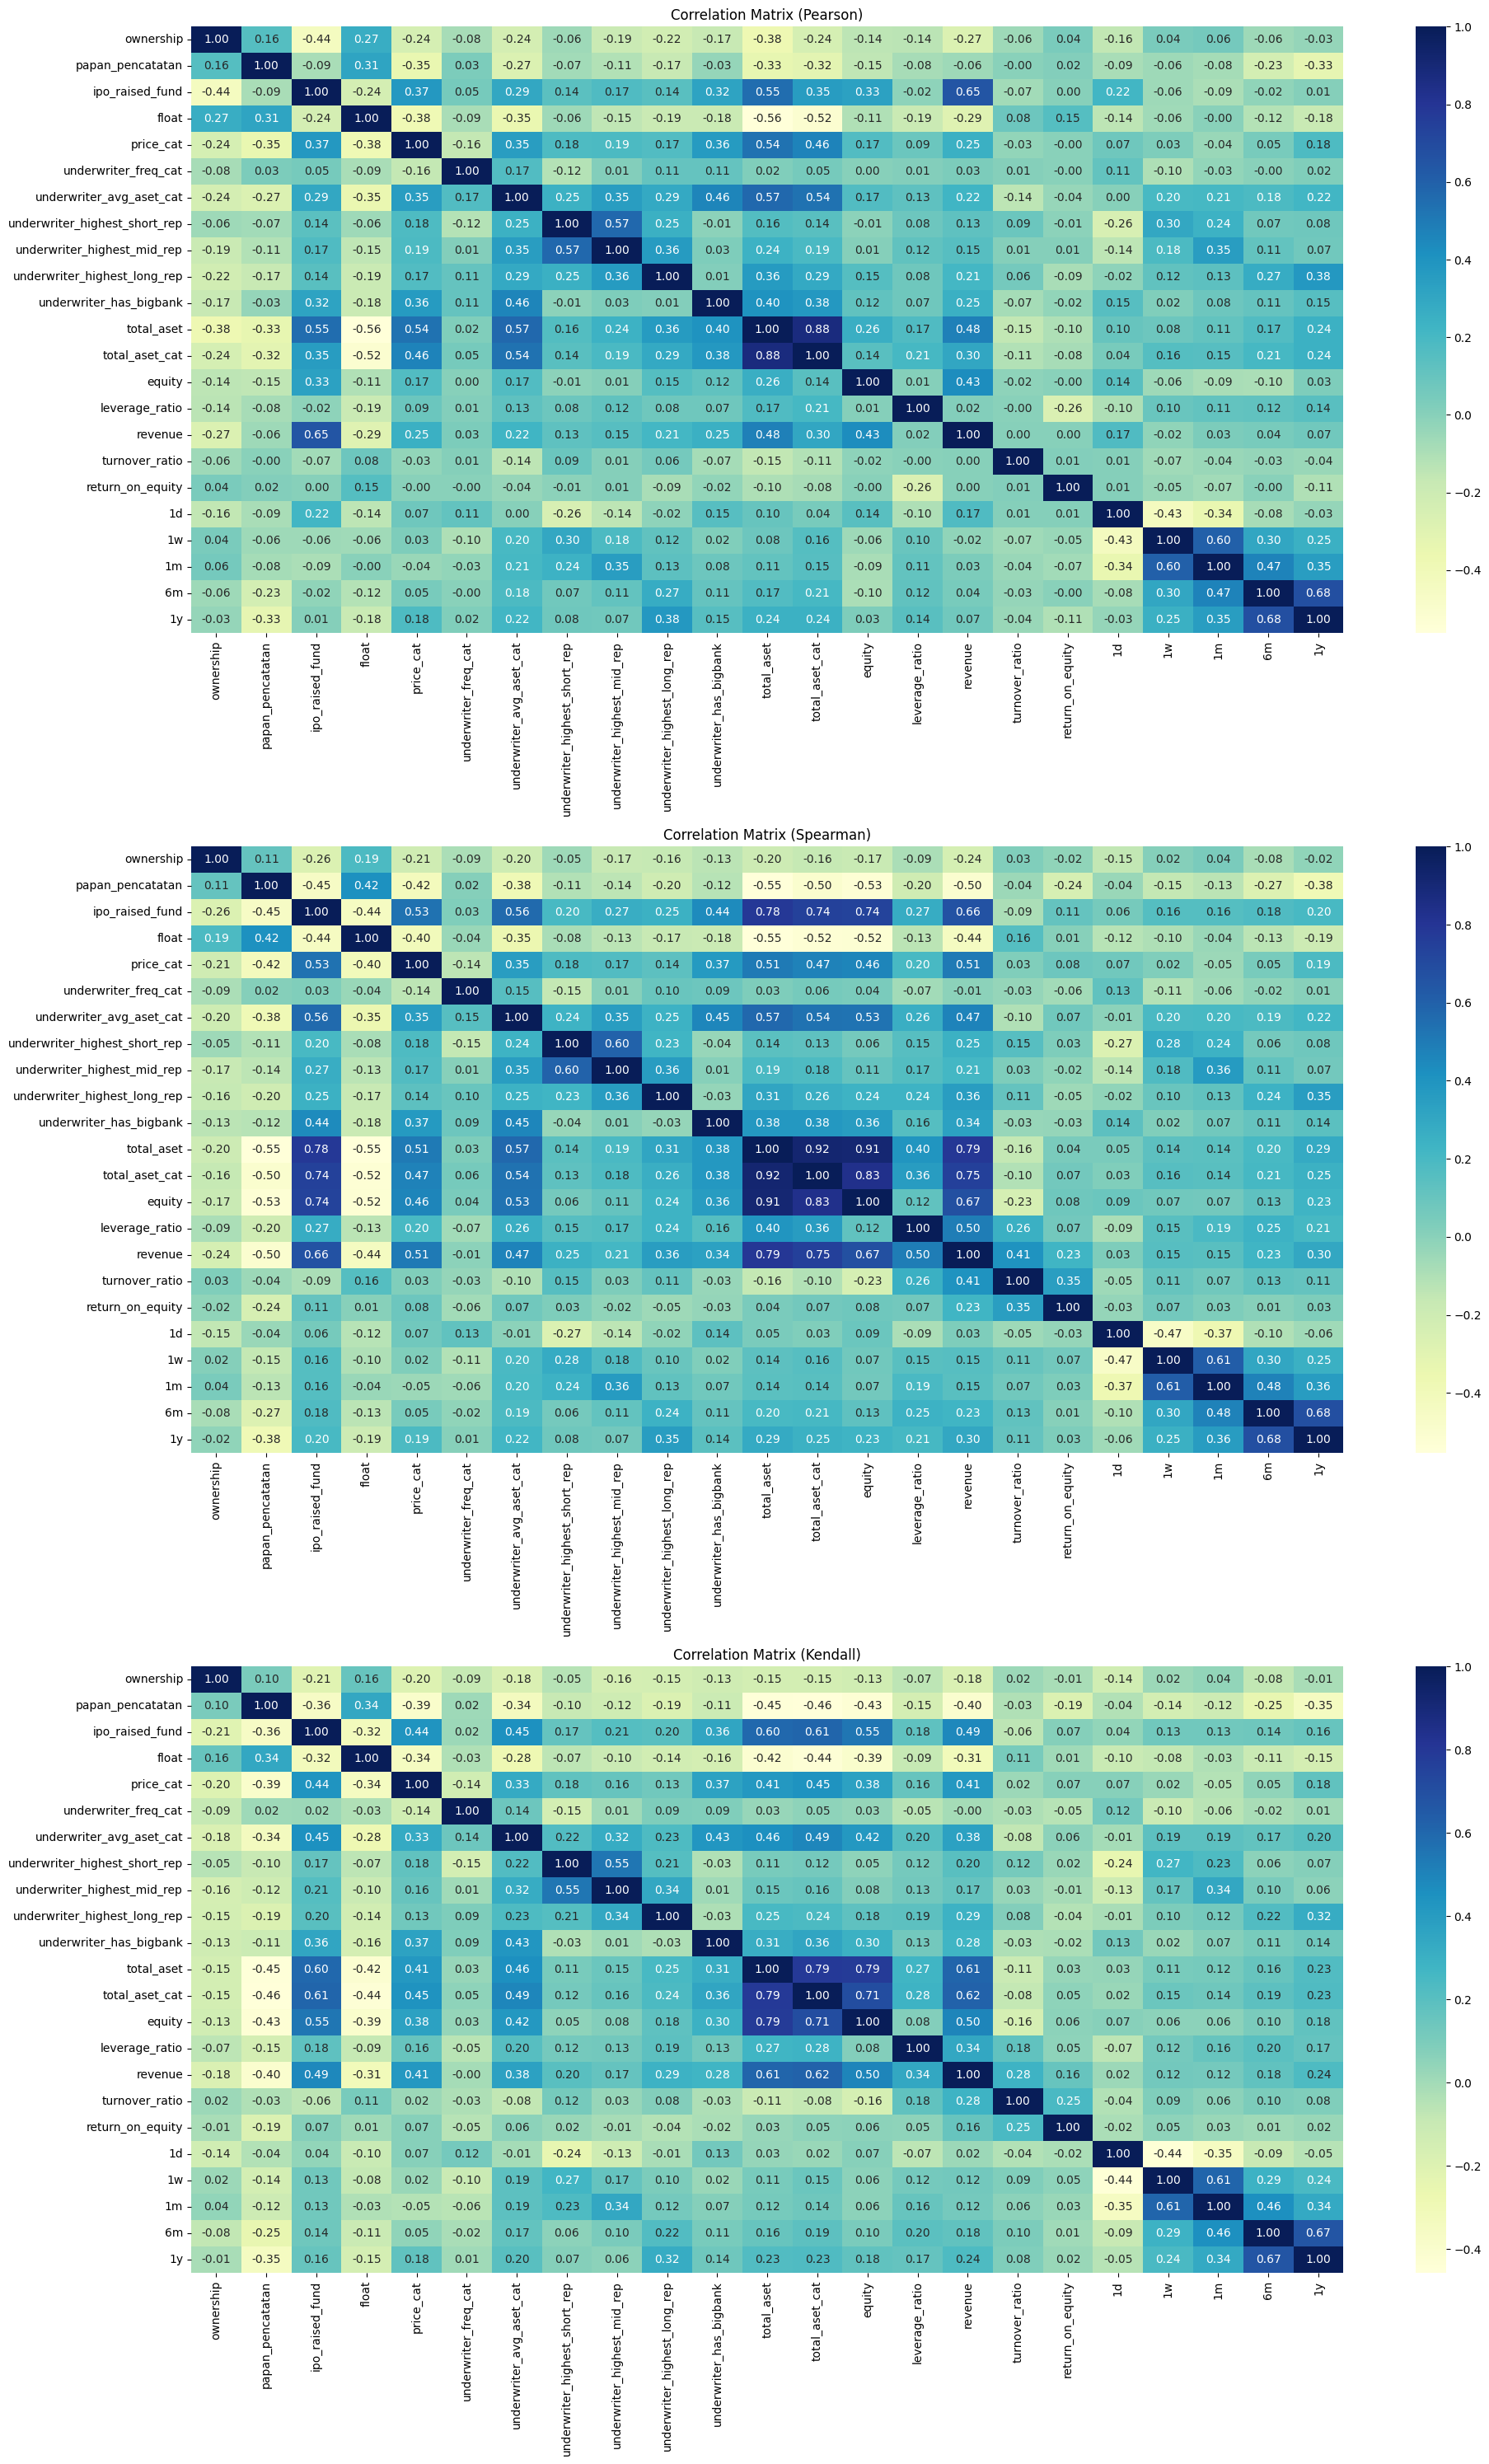

In [13]:
corr_methods = ['pearson', 'spearman', 'kendall']
plt.figure(figsize=(20, 10 * len(corr_methods)))

for i, method in enumerate(corr_methods, 1):
    plt.subplot(len(corr_methods), 1, i)
    corr = df.iloc[:].corr(method=method)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
    plt.title(f'Correlation Matrix ({method.title()})')

plt.tight_layout()
plt.show()

### 1YEAR

In [15]:
feature_cols = [
    'papan_pencatatan', 'ipo_raised_fund', 'float', 'price_cat', 'underwriter_highest_long_rep', 'underwriter_has_bigbank',
    'total_aset_cat', 'equity', 'leverage_ratio', 'revenue', 'turnover_ratio',
]

X = df[feature_cols]
y = df['1y']

mask = y != 1
X = X[mask]
y = y[mask]

y = y.replace({2: 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)


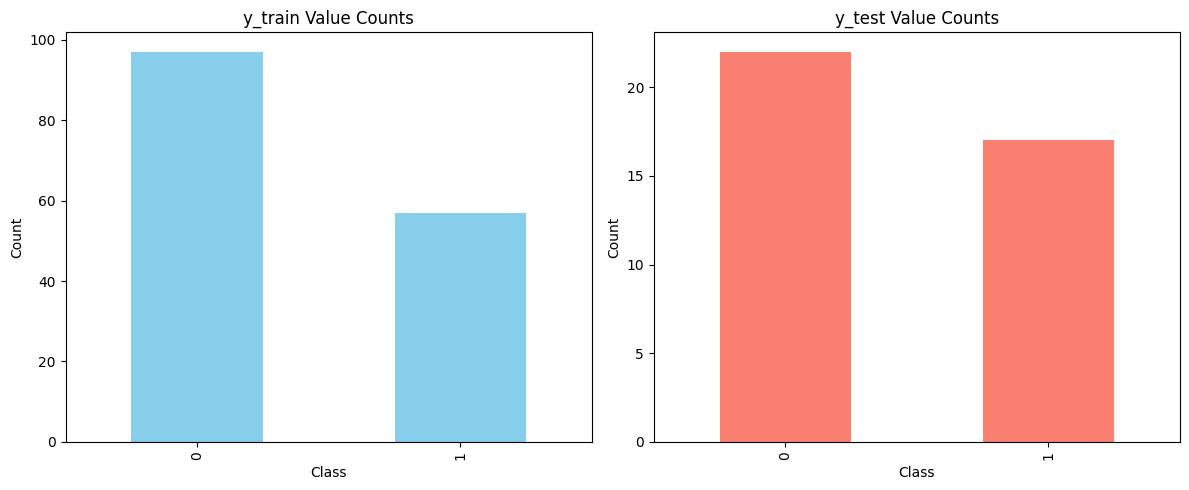

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
y_train.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('y_train Value Counts')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
y_test.value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('y_test Value Counts')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [17]:
print("Before SMOTE:", y_train.value_counts().to_dict())

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train.value_counts().to_dict())

Before SMOTE: {0: 97, 1: 57}
After SMOTE: {0: 97, 1: 97}


c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [18]:
weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), weights))

weight_dict

{0: 0.8109243697478992, 1: 1.304054054054054}

In [23]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

catboost_model = CalibratedClassifierCV(
    estimator=CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=5,
        l2_leaf_reg=10,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42
    ),
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

In [24]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=weights[1] / weights[0],
    random_state=42,
    reg_alpha=0.1
)


In [25]:
ensemble_model = VotingClassifier(
    estimators=[
        ('cat', catboost_model),
        ('rf',  rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft',
    weights=[3, 1, 2]
)

ensemble_model.fit(X_train, y_train)

c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('cat',
                              CalibratedClassifierCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                                                     estimator=<catboost.core.CatBoostClassifier object at 0x000001979DF43970>,
                                                     method='isotonic')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     min_samples_split=5,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.05, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft', weights=[3, 1, 2])

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68        22
           1       0.55      0.35      0.43        17

    accuracy                           0.59        39
   macro avg       0.58      0.56      0.55        39
weighted avg       0.58      0.59      0.57        39



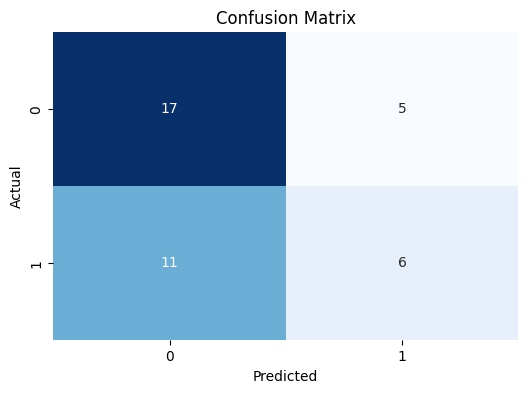

In [26]:
probs = ensemble_model.predict_proba(X_test)[:, 1]
y_pred = (probs > 0.44).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier

catboost_model = CalibratedClassifierCV(
    estimator=CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=5,
        l2_leaf_reg=10,
        loss_function='Logloss',
        auto_class_weights='Balanced',
        verbose=0,
        random_state=42
    ),
    method='isotonic',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
)

In [28]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict

thresholds = np.arange(0.3, 0.61, 0.01)
f1_scores = []

probs = cross_val_predict(
    ensemble_model,
    X, y,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    method='predict_proba'
)[:, 1]

for t in thresholds:
    preds = (probs >= t).astype(int)
    score = f1_score(y, preds, average='macro')
    f1_scores.append(score)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best F1 Macro Score: {best_f1:.4f}")


c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\nathan\

Best Threshold: 0.30
Best F1 Macro Score: 0.6522


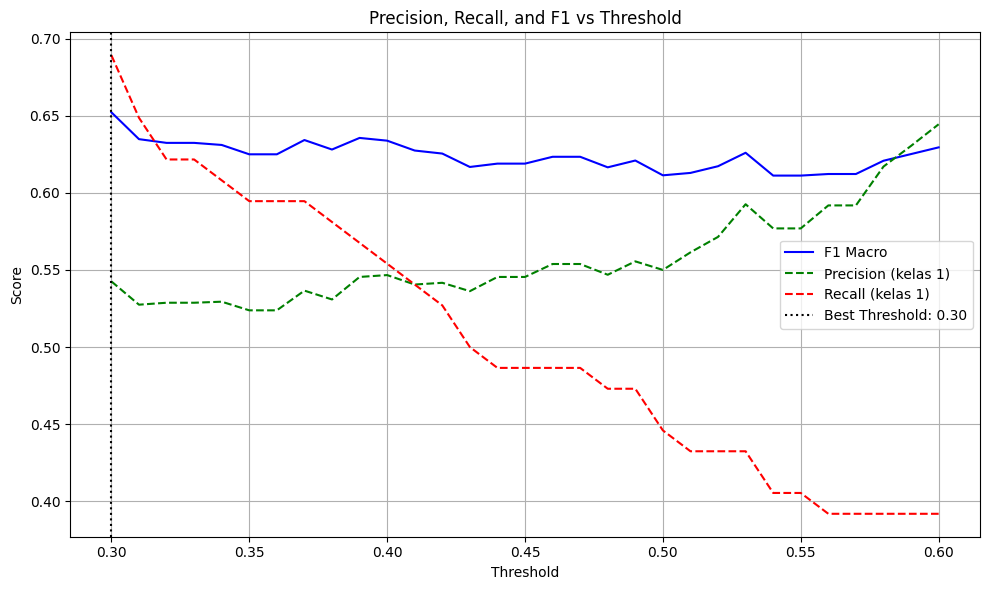

In [29]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

precisions = []
recalls = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(y, preds))
    recalls.append(recall_score(y, preds))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Macro', color='blue')
plt.plot(thresholds, precisions, label='Precision (kelas 1)', linestyle='--', color='green')
plt.plot(thresholds, recalls, label='Recall (kelas 1)', linestyle='--', color='red')
plt.axvline(best_threshold, linestyle=':', color='black', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()